```bash
python -m pip install git+https://github.com/stephwills/fragment_network_merges.git
python -m pip install joblib neo4j im-data-manager-job-utilities pebble
sudo apt-get install ffmpeg libsm6 libxext6  -y
export KUBECONFIG=$HOME/config-fragnet
export NEO4J_USER=matteo
export NEO4J_PASS=👾👾👾
export USE_NEO4J_INSTEAD_API=true
kubectl port-forward -n graph-b graph-0 7474:7474 &
kubectl port-forward -n graph-b graph-0 7687:7687 &
```

In [1]:
import os

os.environ['KUBECONFIG']=os.environ['HOME'] + '/config-fragnet'
os.environ['NEO4J_USER']='matteo'
os.environ['NEO4J_PASS']='👾👾👾'
os.environ['USE_NEO4J_INSTEAD_API']='true'

os.environ['FRAGALYSIS_DATA_DIR'] = os.path.join(os.getcwd(), 'fauxalysis')

assert os.environ['NEO4J_PASS'] != '👾👾👾', 'Fix placeholder...'

In [1]:
## Import hits

from rdkit import Chem

with Chem.SDMolSupplier('hits.filtered.sdf') as sds:
    hits = list(sds)
    
hit_names = [hit.GetProp('_Name') for hit in hits]
hit_smileses = [Chem.MolToSmiles(hit) for hit in hits]
hitdex = dict(zip(hit_names, hits))

In [2]:
## Fauxalysis
import os
from typing import List

def make_fauxalysis(hits: List[Chem.Mol], target_name: str, base_folder='.') -> None:
    if not os.path.exists(base_folder):
        os.mkdir(base_folder)
    os.environ['FRAGALYSIS_DATA_DIR'] = base_folder
    for hit in hits:
        hit_name: str = hit.GetProp('_Name')
        hit_path = os.path.join(base_folder, f'{target_name}', 'aligned',f'{target_name}-{hit_name}')
        os.makedirs(hit_path, exist_ok=True)
        Chem.MolToMolFile(hit, os.path.join(hit_path, f'{target_name}-{hit_name}.mol'))
           
target_name = 'EV-D68-protease'
make_fauxalysis(hits, target_name, os.path.join(os.getcwd(), 'fauxalysis'))

In [3]:
# group1 = ('x1083L0AP1', 'x1305L0BP1', 'x1247L0AP1')
# group2 = ('x0789L0AP1',
#  'x0980L0BP1',
#  'x1604L0AP1',
#  'x1594L0AP1',
#  'x0147L0AP1',
#  'x0771L1AP1','x0771benzo', 'x1604base', 'x1604amino', 'x1604hydroxyl')
# group3 = ('x1285L0BP1')


group1 = ('x1083_0A§1', 'x1305_0B§1', 'x1247_0A§1')
group2 = ('x0789_0A§1',
 'x0980_0B§1',
 'x1604_0A§1',
 'x1594_0A§1',
 'x0147_0A§1',
 'x0771_0A§1','x0771benzo', 'x1604base', 'x1604amino', 'x1604hydroxyl',
         'x1498_0A§1','x1537_0A§1','x1285§1B',
          'ZINC000000080837', 'ZINC000000168472', 'ZINC000012397068', 'ZINC000015042097', 'ZINC000017061891', 'ZINC000001669068', 'ZINC000001674121', 'ZINC000019779146', 'ZINC000224485041', 'ZINC000238711097', 'ZINC000025924635', 'ZINC000026033116', 'ZINC000002289036', 'ZINC000003852685', 'ZINC000039191805', 'ZINC000045921422', 'ZINC000051951618', 'ZINC000005933792', 'ZINC000066323473', 'ZINC000066347860', 'ZINC000072187487', 'ZINC000072482101', 'ZINC000079065151', 'ZINC000082372119', 'ZINC000082372152', 'ZINC000095830806'
         )
group3 = ('x1285_0B§2', 'x1454_0B§1', 'x1020_0A§1')
group4 = ('x0232_0B§3', 'x1453_0B§2')
group5 = ('x1052_0A§2', 'x1285_1B§2', 'x1140_0A§1', 'fippedSulfonamide')
kill = ('x1498_1B§1', 'x1498_0B§1','x0232_0B§3', 'x0771_1A§1', 'x0232_1B§3', 'x1052_1A§2',
       'HOH219','HOH240','HOH318','HOH319','HOH322','HOH323','HOH325', 'HOH67', 'trappedHOH', 'oxyanionHOH')

for name in hit_names:
    for g in (group1, group2, group3, group4, group5, kill):
        if name in g:
            break
    else:
        print(name)

In [4]:
def good(name_pair) -> bool:
    first = -1
    second = -1
    for g, group in enumerate((group1, group2, group3, group4, group5)):
        if name_pair[0] in group:
            first = g
        if name_pair[1] in group:
            second = g
    if first == second:
        return False
    elif first == -1 or second == -1:
        return False
    else:
        return True

In [16]:
## Search

from merge import query
from merge.find_merges import getFragmentNetworkSearcher
from merge.find_merges_generic import MergerFinder_generic  # solely for typehinting
from typing import Dict, List
import gzip, pickle

searcher: MergerFinder_generic = getFragmentNetworkSearcher()

valid_smileses, valid_names = searcher.filter_for_nodes(hit_smileses, hit_names)
smiles_pairs, name_pairs = searcher.get_combinations(valid_smileses, valid_names)
# all_mergers: List[Dict] = []
all_mergers: List[Dict] = globals().get('all_mergers', [])  # in case this is a re-run!

dejavu = [m['smiles_pair'] for m in all_mergers]
groups = ((group1, group2, group3, group4, group5))
for smiles_pair, name_pair in zip(smiles_pairs, name_pairs):
    grouping = [1 if n in group1 else (2 if n in group2 else 3 if n in group3 else 0) for n in name_pair]
    if not good(name_pair):
        continue
    if smiles_pair in dejavu:
        continue
    mergers: Dict[str, List[str]] = searcher.get_expansions(smiles_pair, name_pair, target_name, 'output')
    all_mergers.append(dict(mergers=mergers, smiles_pair=smiles_pair, name_pair=name_pair))

with gzip.open('fragnet_pre.pkl.gz', 'wb') as fh:
    pickle.dump(all_mergers, fh)
    
print(f"N hits: {len(hits)} " + \
      f"N Merger sets: {len(all_mergers)} " + \
      f"N synthons: {sum([len(m['mergers']) for m in all_mergers])} " + \
      f"N mergers: {sum([len(mm) for m in all_mergers for mm in m['mergers'].values()])}")

0 fragments removed from list. 62 fragments remaining.
Expanding fragment A: fippedSulfonamide with synthons of fragment B: ZINC000066323473
Found 6 synthons
4 synthons remaining after filtering
Running synthon 0
Synthon 0: found 639 expansions
Running synthon 1
Synthon 1: found 0 expansions
Running synthon 2
Synthon 2: found 0 expansions
Running synthon 3
Synthon 3: found 1 expansions
640 expansions from 2 out of 4 synthons


Expanding fragment A: fippedSulfonamide with synthons of fragment B: ZINC000066347860
Found 2 synthons
1 synthons remaining after filtering
Running synthon 0
Synthon 0: found 639 expansions
639 expansions from 1 out of 1 synthons


Expanding fragment A: fippedSulfonamide with synthons of fragment B: ZINC000072187487
Found 2 synthons
1 synthons remaining after filtering
Running synthon 0
Synthon 0: found 0 expansions
0 expansions from 0 out of 1 synthons


Expanding fragment A: fippedSulfonamide with synthons of fragment B: ZINC000072482101
Found 2 synthons
1 synt

In [17]:
print(f"N hits: {len(hits)} " + \
      f"N Merger sets: {len(all_mergers)} " + \
      f"N synthons: {sum([len(m['mergers']) for m in all_mergers])} " + \
      f"N mergers: {sum([len(mm) for m in all_mergers for mm in m['mergers'].values()])}")

N hits: 65 N Merger sets: 810 N synthons: 3609 N mergers: 859825


In [54]:
x = pd.DataFrame({'n1': placed_synthons['name'].reset_index(drop=True),
                 'n2': synthons['name'].reset_index(drop=True)})
x.loc[x.n1 != x.n2]

,n1,n2
0,x1453-0B-2S1,x1453_0B§2S1
1,x1453-0B-2S2,x1453_0B§2S2
2,x1453-0B-2S3,x1453_0B§2S3
3,x1453-0B-2S4,x1453_0B§2S4
4,x1453-0B-2S5,x1453_0B§2S5
...,...,...
125,x1285-1B-2S5,x1285_1B§2S5
126,x1285-1B-2S6,x1285_1B§2S6
127,x1285-1B-2S7,x1285_1B§2S7
128,x1140-0A-1S1,x1140_0A§1S1


In [56]:
## Parse synthons

import operator
import pandas as pd
from fragmenstein import Victor, Laboratory, Igor
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, BRICS
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import pandera.typing as pdt
from typing import List, Dict
import logging
import pyrosetta_help as ph
import pyrosetta

logger = ph.configure_logger()
logger.handlers[0].setLevel(logging.ERROR)

with open('reference.pdb') as fh:
    pdb_block = fh.read()

dfs = [ pd.DataFrame([{'smiles': synthon.replace('Xe', 'H'),
                       'original_name': f'{merge_info["name_pair"][1]}-synthon{i}',
                       'xenonic': synthon,
                       'parent': merge_info['name_pair'][1],
                       'hits': [hitdex[merge_info['name_pair'][1]]]} for i, synthon in enumerate(merge_info['mergers'].keys())])
       for merge_info in all_mergers
      ]

synthons = pd.concat(dfs, axis='index')

# fix duplicated
synthons.reset_index(drop=True, inplace=True)
synthons['inchi'] = synthons.smiles.apply(Chem.MolFromSmiles).apply(Chem.RemoveAllHs).apply(Chem.MolToInchiKey)    
synthons = synthons.drop_duplicates(['parent', 'inchi'])
synthons['name'] = synthons.parent +'S'+ (synthons.groupby(['parent']).cumcount()+1).astype(str)
Igor.init_pyrosetta()
placed_synthons = Laboratory(pdbblock=pdb_block, covalent_resi=None).place(synthons, n_cores=55)
placed_synthons.reset_index(drop=True, inplace=True)

def fix_name(row):
    # error... min_mol has it. not unmin.
    mol = Chem.Mol(row.unmin_binary)
    mol.SetProp('_Name', row['name'])
    return mol
    
#name_check = placed_synthons['name']
#assert (name_check != synthons['name']).sum() == 0, 'crap... tables are offset'
synthons = synthons.reset_index(drop=True)
placed_synthons = placed_synthons.reset_index(drop=True)
synthons['∆∆G'] = placed_synthons['∆∆G']
synthons['unmin_mol'] = placed_synthons.apply(fix_name, axis=1)
from rdkit.Chem import PandasTools
PandasTools.WriteSDF(df=synthons,
                     out='fragnet-synthons.sdf',
                     molColName='unmin_mol', 
                     idName='name',
                     properties=['parent', '∆∆G'])

In [5]:
# relaoded.... DEL
import gzip, pickle
import operator
import pandas as pd
from fragmenstein import Victor, Laboratory, Igor
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, BRICS
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import pandera.typing as pdt
from typing import List, Dict
import logging
import pyrosetta_help as ph
import pyrosetta

logger = ph.configure_logger()
logger.handlers[0].setLevel(logging.ERROR)

with open('reference.pdb') as fh:
    pdb_block = fh.read()
from rdkit.Chem import PandasTools

synthons = PandasTools.LoadSDF('fragnet-synthons.sdf',
                     molColName='unmin_mol', 
                     idName='name',)

# fix numerics
synthons['∆∆G'] = synthons['∆∆G'].astype(float)

with gzip.open('fragnet_pre.pkl.gz', 'rb') as fh:
    all_mergers = pickle.load(fh)
    
Igor.init_pyrosetta()

/home/ubuntu/miniconda3/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [6]:
synthons['smiles'] = synthons.unmin_mol.apply(Chem.MolToSmiles)

In [7]:
synthons['inchi'] = synthons.smiles.apply(Chem.MolFromSmiles).apply(Chem.RemoveAllHs).apply(Chem.MolToInchiKey)    

DONE


,parent,∆∆G,name,unmin_mol,smiles,inchi
0,x1453_0B§2,-1.526244,x1453_0B§2S1,,Brc1ccccc1,QARVLSVVCXYDNA-UHFFFAOYSA-N
1,x1453_0B§2,-1.266183,x1453_0B§2S2,,O=C(O)c1ccccc1,WPYMKLBDIGXBTP-UHFFFAOYSA-N
2,x1453_0B§2,-0.945659,x1453_0B§2S3,,Oc1cccc(Br)c1,MNOJRWOWILAHAV-UHFFFAOYSA-N
3,x1453_0B§2,-1.173491,x1453_0B§2S4,,O=C(O)c1ccc(Br)cc1,TUXYZHVUPGXXQG-UHFFFAOYSA-N
4,x1453_0B§2,-1.009903,x1453_0B§2S5,,O=C(O)c1ccccc1O,YGSDEFSMJLZEOE-UHFFFAOYSA-N
...,...,...,...,...,...,...
125,x1285_1B§2,-0.906429,x1285_1B§2S5,,c1ccsc1,YTPLMLYBLZKORZ-UHFFFAOYSA-N
126,x1285_1B§2,-1.185219,x1285_1B§2S6,,OC1CCNCC1,HDOWRFHMPULYOA-UHFFFAOYSA-N
127,x1285_1B§2,-1.052151,x1285_1B§2S7,,c1cc(CN2CCCCC2)cs1,SWHHNIUDRFDQFR-UHFFFAOYSA-N
128,x1140_0A§1,-2.000299,x1140_0A§1S1,,c1ccc2c(c1)OCO2,FTNJQNQLEGKTGD-UHFFFAOYSA-N

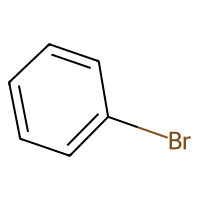
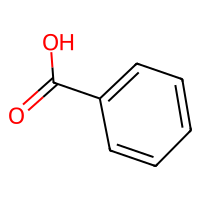
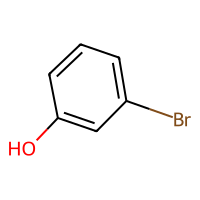
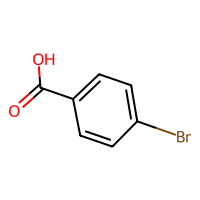
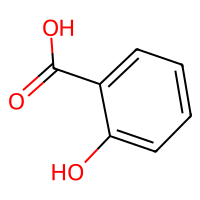
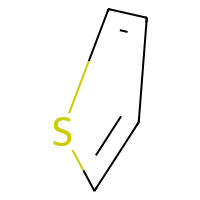
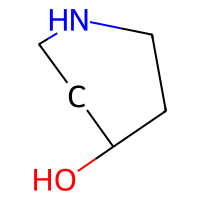
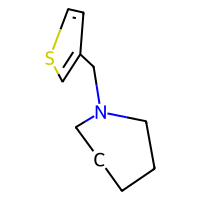
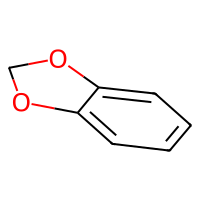
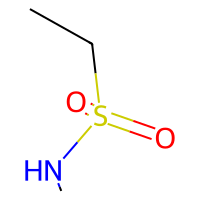

In [8]:
print('DONE')
synthons

In [12]:
# fix names of synthons in combination and make it a long table
data = []
combodex: dict
for combodex in all_mergers:
    # 'mergers', 'smiles_pair', 'name_pair'
    first_name, second_name = combodex['name_pair']
    first: Chem.Mol = hitdex[first_name]
    for synthon_smiles in combodex['mergers']:
        clean_smiles = synthon_smiles.replace('Xe', 'H')
        inchi = Chem.MolToInchiKey( Chem.RemoveAllHs( Chem.MolFromSmiles(clean_smiles) ) )
        matched = synthons.loc[(synthons['parent'] == second_name) & (synthons.inchi == inchi)]
        if len(matched) == 0:
            print(second_name, clean_smiles, 'missing!')
            # Z2111637360
            second = hitdex[second_name]
            synthon_name = second_name+'X'
        elif matched.iloc[0]['∆∆G'] > -1.:
            # skip crap floater fragments
            continue
        else:
            second = matched.iloc[0].unmin_mol
            synthon_name = matched.iloc[0]['name']
        for i, smiles in enumerate(combodex['mergers'][synthon_smiles]):
            name = f'{first_name}-{synthon_name}-{i}'
            data.append(dict(name=name,
                             hits=[first, second], 
                             primary_name=first_name, 
                             secondary_parent=second_name, 
                             secondary_name=synthon_name,
                             smiles=smiles.replace('Xe', 'H')))
tabular_combinations = pd.DataFrame(data)

x1604_0A§1 CC1OC(=O)c2cc(Br)c([H])cc2O1 missing!
x1604_0A§1 CC1([H])OC(=O)c2cc(Br)ccc2O1 missing!
x1604_0A§1 CC1([H])OC(=O)c2ccc(O)cc2O1 missing!
x1604_0A§1 CC1([H])OC(=O)c2cc(Br)c(O)cc2O1 missing!
x1604_0A§1 CC1OC(=O)c2ccc([H])cc2O1 missing!
x1604_0A§1 CC1OC(=O)c2cc([H])c(O)cc2O1 missing!
x1604_0A§1 CC1OC(=O)c2cc([H])ccc2O1 missing!
x1604_0A§1 CC1([H])OC(=O)c2ccccc2O1 missing!
x1604_0A§1 CC1OC(=O)c2cc(Br)c([H])cc2O1 missing!
x1604_0A§1 CC1([H])OC(=O)c2cc(Br)ccc2O1 missing!
x1604_0A§1 CC1([H])OC(=O)c2ccc(O)cc2O1 missing!
x1604_0A§1 CC1([H])OC(=O)c2cc(Br)c(O)cc2O1 missing!
x1604_0A§1 CC1OC(=O)c2ccc([H])cc2O1 missing!
x1604_0A§1 CC1OC(=O)c2cc([H])c(O)cc2O1 missing!
x1604_0A§1 CC1OC(=O)c2cc([H])ccc2O1 missing!
x1604_0A§1 CC1([H])OC(=O)c2ccccc2O1 missing!
x1604_0A§1 CC1OC(=O)c2cc(Br)c([H])cc2O1 missing!
x1604_0A§1 CC1([H])OC(=O)c2cc(Br)ccc2O1 missing!
x1604_0A§1 CC1([H])OC(=O)c2ccc(O)cc2O1 missing!
x1604_0A§1 CC1([H])OC(=O)c2cc(Br)c(O)cc2O1 missing!
x1604_0A§1 CC1OC(=O)c2ccc([H])cc2O1 miss

In [10]:
tabular_combinations.secondary_name.value_counts()

secondary_name
x1453_0B§2S6          202617
x1020_0A§1S5          200273
x1604hydroxylS4        30172
x1604aminoS3           30172
x1604baseS1            30172
x0771benzoS1           30172
x1052_0A§2S1           14821
x1140_0A§1S1           13118
x0232_0B§3S1            8147
x1498_0A§1S1            7404
x1454_0B§1S4            6971
x0980_0B§1S11           6158
x1594_0A§1S1            3436
x1052_0A§2S3            2228
x0771_0A§1S1             897
x1140_0A§1S2             683
ZINC000019779146S2       400
ZINC000012397068S1       349
ZINC000000168472S1       349
ZINC000095830806S1       349
ZINC000082372152S1       349
ZINC000051951618S1       349
ZINC000003852685S1       349
x1285_0B§2S3             164
ZINC000001674121S2        88
ZINC000045921422S1        88
ZINC000001669068S1        51
ZINC000238711097S2        51
ZINC000224485041S1        43
ZINC000039191805S1         2
ZINC000000080837S1         1
ZINC000015042097S1         1
ZINC000025924635S1         1
ZINC000072482101S1         1

In [13]:
logger = ph.configure_logger()
Victor.enable_stdout(logging.CRITICAL)
#Victor.journal.handlers[0].setLevel(logging.ERROR)
#Victor.journal.setLevel(logging.ERROR)

In [36]:
from rdkit.Chem import rdFMCS
from fragmenstein.error import FragmensteinError


class Quicktor(Victor):
    quick_reanimation = True
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.monster.matching_modes = [{'atomCompare': rdFMCS.AtomCompare.CompareElements,
                           'bondCompare': rdFMCS.BondCompare.CompareOrder,
                           'ringCompare': rdFMCS.RingCompare.PermissiveRingFusion,
                           'ringMatchesRingOnly': True}]
    
    def post_monster_step(self):
        mapping = self.monster.convert_origins_to_custom_map()
        for hit in self.monster.hits:
            hit_name = hit.GetProp('_Name')
            if hit_name not in mapping:
                raise FragmensteinError('Failed mapping')
            if all([k < 0 for k in mapping[hit_name]]):
                raise FragmensteinError('Failed mapping')
    
    
    def _get_preminimized_undummied_monster(self) -> Chem.Mol:
        """
        This method is called by the plonking into structure methods.
        Not "positioning" as intended by ``monster`` is done.
        Opening a PDB in RDKit is doable but gets exponentially slow with chain length
        """
        mol = Chem.Mol(self.monster.positioned_mol)
        if self.monster_mmff_minisation:
            self.journal.debug(f'{self.long_name} - pre-minimising monster (MMFF)')
            if not self.monster.mmff_minimize(mol, allow_lax=False, ff_dist_thr=float('nan')):
                raise FragmensteinError('Could not preminize')
        return AllChem.DeleteSubstructs(mol, Chem.MolFromSmiles('*')) 

In [ ]:
## Place enumerations
    
lab = Laboratory(pdb_block, None)
lab.Victor = Quicktor
Quicktor.monster_throw_on_discard = False  # currently there's a glitch as it throws if disconnected.
placed = lab.place(tabular_combinations, n_cores=55, expand_isomers=False)
with gzip.open('fragnet.placed.pkl.gz', 'wb') as fh:
    placed.to_pickle(fh)
placed.sort_values('∆∆G', ascending=True)

In [ ]:
1

In [ ]:
placed.error.str.split(' ', expand=True)[0].value_counts()

In [ ]:
placed.loc[(placed.outcome == 'acceptable') & (placed['∆∆G'] <= -2)].sort_values('∆∆G', ascending=True)

In [ ]:
from rdkit.Chem import PandasTools

valids = placed.loc[(placed.outcome == 'acceptable') & (placed.minimized_mol.apply(lambda m: isinstance(m, Chem.Mol)))]\
                  .sort_values('∆∆G').drop_duplicates('name')

In [ ]:
from rdkit.Chem import AllChem
from merge import query
from merge.find_merges import getFragmentNetworkSearcher
from merge.find_merges_generic import MergerFinder_generic  # solely for typehinting
from typing import Dict, List
import gzip, pickle

searcher: MergerFinder_generic = getFragmentNetworkSearcher()

# get names!

def get_names(smiles: str) -> str:
    #placed_synthons['catalogue_name'] = placed_synthons.clean_smiles.apply(get_name)
    
    try:
        with searcher.getSearchSession() as session:
            node = session.find_molecule_node(smiles)
            return node['cmpd_ids']
    except Exception as error:
        print(error)
        return ''

#get_names(valids.iloc[0].smiles)
valids['catalogue_names'] = valids.smiles.apply(get_names)

In [ ]:
i = 0

def get_first_name(names: List[str]) -> str:
    if len(names) == 0:
        global i
        i += 1
        return f'UNKNOWN{i}'
    for name in names:
        if 'ENAMINE:' in name:
            return name
    return names[0]
    

valids['catalogue_name'] = valids.catalogue_names.apply(get_first_name)

In [ ]:
from pathlib import Path

valids['path'] = valids.name.apply(lambda n: Path('output') / n / f'{n}.holo_minimised.pdb')
valids.path.apply(Path.exists).value_counts()

In [ ]:
valids.to_pickle('fragnet_acceptables.pkl.gz')
PandasTools.WriteSDF(df=valids,
                    out=f'fragnet_placements.sdf',
                    molColName='minimized_mol',
                    idName='name',
                    properties=['regarded', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome', 'catalogue_name',
       'percent_hybrid']
                    )

valids[['name', 'regarded', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome', 'catalogue_name',
       'percent_hybrid']].to_csv(f'fragnet_placements.csv')

In [ ]:
len(valids)

In [ ]:
"""
https://github.com/matteoferla/PLIP-PyRosetta-hotspots-test/blob/main/plipspots_docking/plipspots/serial.py

This is a class I use to _apply_ PLIP to a pd.Series of molecules.
It is not built for the project, but works.
Note I have not dumped the methods that are not needed for the project.
"""

import os
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from functools import singledispatchmethod
from typing import Tuple, Dict, List, Union
from collections import Counter, defaultdict
from plip.structure.preparation import PDBComplex, PLInteraction
from openbabel.pybel import Atom, Residue
from openbabel.pybel import ob
from fragmenstein.victor import MinimalPDBParser
import warnings


class SerialPLIPper:
    """
    Calling the instance will return a ``Dict[Tuple[str, str, int], int]``,
    where the key is interaction type, residue 3-letter name, residue index
    and the value is the count of interactions.
    Basically, applying Plip to a pd.Series of Chem.Mol.

    Unplacking it is kind of wierd, the best way I reckon is a brutal for-loop:

    .. code-block:: python

        import pandas as pd
        import pandera.typing as pdt

        intxndexes: pdt.Series[Dict[Tuple[str, str, int], int]] = hits.ROMol.apply(SerialPLIPper(pdb_filename))
        # columns will still be a tuple...:
        intxn_df = pd.DataFrame(intxndexes.to_list()).fillna(0).astype(int)
        hits['N_interactions'] = intxn_df.sum(axis='columns')
        for c in sorted(intxn_df.columns, key=lambda kv: kv[2]):
            # columns will be a colon-separated string:
            hits[':'.join(map(str, c))] = intxn_df[c]
    """

    def __init__(self, pdb_block: str, resn='LIG', chain='B'):
        assert 'ATOM' in pdb_block, f'No ATOM entry in block provided: {pdb_block}'
        self.pdb_block = pdb_block
        self.resn = resn
        self.chain = chain

    @classmethod
    def from_filename(cls, pdb_filename: str, *args, **kwargs):
        """
        The main constructor is from PDB block, this is from PDB file
        """
        with open(pdb_filename, 'r') as f:
            pdb_block = f.read()
        return cls(pdb_block, *args, **kwargs)

    def __call__(self, mol) -> Dict[Tuple[str, str, int], int]:
        if mol is None or not isinstance(mol, Chem.Mol) or mol.GetNumAtoms() == 0:
            return {}
        holo: str = self.plonk(mol)
        interaction_set: PLInteraction = self.get_interaction_set(holo)
        return self.get_interaction_counts(interaction_set)

    def assign_pdb(self, mol: Chem.Mol):
        """
        Fix the PDB info for the molecule, in place
        """
        counts = defaultdict(int)
        atom: Chem.Atom
        for atom in mol.GetAtoms():
            element: str = atom.GetSymbol()
            counts[element] += 1
            info = Chem.AtomPDBResidueInfo(atomName=f'{element: >2}{counts[element]: <2}',
                                           residueName=self.resn,
                                           residueNumber=1, chainId=self.chain)
            atom.SetPDBResidueInfo(info)

    def plonk(self, mol):
        """
        Temporarily here. Do not copy.
        There likely is a way to do this in OBabel
        This is using Fragmenstein ``MinimalPDBParser``.

        :param mol:
        :return:
        """
        pdbdata = MinimalPDBParser(self.pdb_block, remove_other_hetatms=True, ligname=self.resn)
        self.assign_pdb(mol)
        moldata = MinimalPDBParser(Chem.MolToPDBBlock(mol))
        pdbdata.append(moldata)
        return str(pdbdata)

    @singledispatchmethod
    def get_interaction_set(self) -> PLInteraction:
        """
        Overloaded method: block or mol return the iternaction set
        :return:
        """
        raise NotImplementedError

    @get_interaction_set.register
    def _(self, block: str) -> PLInteraction:
        holo = PDBComplex()
        holo.load_pdb(block, as_string=True)
        holo.analyze()
        return holo.interaction_sets[':'.join([self.resn, self.chain, str(1)])]

    @get_interaction_set.register
    def _(self, mol: Chem.Mol) -> PLInteraction:
        if mol.GetNumAtoms() == 0:
            raise ValueError('Molecule has no atoms')
        holo = PDBComplex()
        holo.load_pdb(self.plonk(mol), as_string=True)
        holo.analyze()
        return holo.interaction_sets[':'.join([self.resn, self.chain, str(1)])]

    def get_atomname(self, atom: Union[Atom, ob.OBAtom]) -> str:
        """
        Given an atom, return its name.
        """
        if isinstance(atom, Atom):
            res: ob.OBResidue = atom.residue.OBResidue
            obatom = atom.OBAtom
        elif isinstance(atom, ob.OBAtom):
            obatom: ob.OBAtom = atom
            res: ob.OBResidue = obatom.GetResidue()
        else:
            raise TypeError
        return res.GetAtomID(obatom)

    def get_atom_by_atomname(self, residue: Union[ob.OBResidue, Residue], atomname: str) -> ob.OBAtom:
        """
        Get an atom by its name in a residue.
        """
        if isinstance(residue, Residue):
            residue = residue.OBResidue
        obatom: ob.OBAtom
        for obatom in ob.OBResidueAtomIter(residue):
            if residue.GetAtomID(obatom).strip() == atomname:
                return obatom
        else:
            raise ValueError(f'No atom with name {atomname} in residue {residue.GetName()}')

    def get_interaction_counts(self, interaction_set: PLInteraction) -> Dict[Tuple[str, str, int], int]:
        """
        Count the number of interactions of each type for each residue
        """
        intxns: List = interaction_set.all_itypes
        intxn_dex = defaultdict(int)
        for intxn in intxns:
            key = (intxn.__class__.__name__, intxn.restype, intxn.resnr)
            intxn_dex[key] += 1
        return dict(sorted(intxn_dex.items(), key=lambda kv: kv[0][2]))

In [ ]:
chain_check = {l[21:26].strip() for l in valids.iloc[0].path.read_text().split('\n') if ' LIG ' in l} - {'LIG'}
print(chain_check)
chain = next(iter(chain_check)).split()[0]

import operator

plipper = SerialPLIPper('ATOM', resn='LIG', chain=chain)
def get_intxns(path: Path) -> dict:
    interaction_set: PLInteraction = plipper.get_interaction_set(path.read_text())
    return plipper.get_interaction_counts(interaction_set)

intxns = valids.path.apply(get_intxns)
key_order = sorted(set(intxns.apply(lambda d: list(d.keys())).sum()), key=operator.itemgetter(2))
for key in key_order:
    valids[key] = intxns.apply(lambda d: d.get(key, 0))
valids['N_interactions'] = valids[key_order].sum(axis=1)

valids.to_pickle('acceptables.pkl.gz')
valids[['name', 'regarded', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome',
       'percent_hybrid', 'N_interactions'] + key_order].to_csv('fragnet_interactions.csv')
print('done')

In [ ]:
valids['N_interactions'].value_counts().sort_index()

In [ ]:
import re

def unbleach2(name: str, raise_error=True):
    regex = re.match(r'(x\d+)L(\w+)P(\d+)', name)
    if regex:
        return f'{regex.group(1)}@{regex.group(2)}-{regex.group(3)}'
    # special
    regex = re.match(r'(x\d+\w+)S', name)
    if regex:
        return f'{regex.group(1)}'
    regex = re.match(r'(x\d+\w+)', name)
    if regex:
        return f'{regex.group(1)}'
    if raise_error:
        raise Exception(name)
    return name
    
valids['hit_names'] = valids.regarded.apply(lambda l: [unbleach2(n) for n in l])

In [ ]:
from michelanglo_api import MikeAPI
from rdkit import Chem
from typing import List
import pandas as pd
import json

# declare variables
hit_names = [unbleach2(n, False) for n in hitdex]
!mkdir -p upload
!cp filtered_hits.sdf upload/EV-D68_hits2.sdf
hit_filename = 'EV-D68_hits2.sdf'

headers = ['name', 'hits', 'code', 'RMSD', '∆∆G', 'LE', 'N unconstrained atoms', 'N constrained atoms', 'N interactions']
metadata: pd.DataFrame = valids.rename(columns=dict(hit_names='hits', comRMSD='RMSD',
                                                    dist='distance',
                                                    catalogue_name='code',
                                                    N_constrained_atoms='N constrained atoms',
                                                    N_unconstrained_atoms='N unconstrained atoms',
                                                    N_interactions='N interactions'))[headers]
metadata_filename: str = 'EV-D68_metadata2.json'

for k in ('∆∆G', 'LE', 'RMSD'):
    metadata[k] = metadata[k].fillna(999).astype(float).round(1)
for k in ('N unconstrained atoms',):
    metadata[k] = metadata[k].fillna(-1).astype(int)
metadata = metadata.copy()


base_url = 'https://www.stats.ox.ac.uk/~ferla/mols/'  # base url path
uuid = 'e934e6d1-61e4-4fe8-b57f-166bd5e37c31' # uuid of the page target

placement_filename = 'EV-D68_fragnet.sdf'
with Chem.SDWriter('upload/'+ placement_filename) as sdw:
    placement_names = []
    for i, row in valids.iterrows():
        row.minimized_mol.SetProp('_Name', row['name'])
        if row.minimized_mol.GetNumAtoms() == 0:
            continue
        sdw.write(row.minimized_mol)
        placement_names.append(row['name'])
        
with open('upload/'+ metadata_filename, 'w') as fh:
    json.dump(dict(
                   headers=headers,
                   data=metadata.values.tolist(),
                   modelnamedex={'fragnet': placement_names,
                                },
                   hitnames=hit_names,
            ), fh)
    
# make a page

mike = MikeAPI()
page = mike.get_page(uuid)

page.loadfun = page.get_fragment_js(hit_sdf_url=base_url+hit_filename,
                               model_sdf_urldex={'fragnet' : base_url+placement_filename,
                                                },
                               metadata_url=base_url+metadata_filename,
                               model_colordex={'fragnet': 'salmon'},
                               hit_color='grey',
                               template_color='gainsboro',
                               name_col_idx = headers.index('name'),
                               hit_col_idx = headers.index('hits'),
                               target_col_idx = -1, # headers.index('target')
                               sort_col = headers.index('N interactions'),
                               sort_dir = 'desc',
                               fun_name ='loadTable')

# create a way to load the protein
# laziest: 
#page.loadfun += 'setTimeout(loadTable, 1000)'
# better:
page.loadfun += """
window.loadprotein = (prot) => {prot.removeAllRepresentations(); 
                                prot.addRepresentation('cartoon');
                                prot.addRepresentation('line');
                                prot.autoView(); 
                                prot.setName('template');
                                loadTable(); 
                                }
"""
page.loadfun = page.loadfun.replace('"model_colordex": {"combination": "teal", "placement": "teal"}',
                                    '"model_colordex": {"combination": "salmon", "placement": "turquoise"}'
                                   )
page.proteins[0]['loadFx'] = 'loadprotein'
page.title = 'EV-D68 3C protease followups — Fragment Network'
page.description = f'## Predicted followups\n Followups in salmon.\n\n. Protein is constant for the sake of memory, but induced fit may have repacked the protein in specific case hence the odd case of calculated nice score and visual clashes.\n\nRMSD cutoff loosened to 2Å'
page.columns_text = 6
page.commit()
print('Done')

In [ ]:
tabular_combinations.loc[tabular_combinations['name'].str.contains('x1285L0BP1S6') & (tabular_combinations.primary_name == 'x0771benzo')]

In [ ]:
tabular_combinations

In [ ]:
## Junkyard

In [ ]:
# there is an issue. Benzene is winning...
import functools, operator

used = list(set(functools.reduce(operator.add, valids.regarded.to_list(), [])))
used

In [ ]:
Chem.MolFromSmiles(synthons.set_index('name').loc['x1604hydroxylS4'].smiles)

In [ ]:
good_names = ['x1285L0BP1S3',
 'x0771L1AP1S1',
 'x0980L0BP1S11',
 'x1285L0BP1',
 'x1594L0AP1S1',
 'x1083L0AP1']

def is_nonbenzene(l):
    for n in l:
        if l not in good_names:
            return False
    return True

valids['_keep'] = valids.regarded.apply(is_nonbenzene)
valids._keep.value_counts()

In [ ]:

Chem.MolToSmiles(AllChem.RemoveAllHs(synthons.set_index('name').loc['x1285L0BP1S6'].unmin_mol))

In [ ]:
Chem.MolFromSmiles()

In [ ]:
faux = pd.DataFrame([dict(name='test',
                          smiles='NC(=O)c1ccc(CCCCCCCCCC2CCNCC2)cc1',
                          hits=[hitdex['x0771benzo'],
                                synthons.set_index('name').loc['x1285L0BP1S6'].unmin_mol])])

In [ ]:
lab.place(faux, n_cores=55, expand_isomers=False)

In [ ]:
from fragmenstein import Monster

Monster.journal.setLevel(logging.DEBUG)
Monster.journal.handlers[0].setLevel(logging.DEBUG)

h = [hitdex['x0771benzo'],
         synthons.set_index('name').loc['x1285L0BP1S6'].unmin_mol]

#Monster(h).place_smiles('NC(=O)c1ccc(CCCCCCCCCC2CCNCC2)cc1').positioned_mol

In [ ]:
v = Victor(h, pdb_block=pdb_block)
v.place('NC(=O)c1ccc(CCCCCCCCCC2CCNCC2)cc1').minimized_mol

In [ ]:
v.monster._compute_overlaps()